# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

Next things to try:

- decrease fst_dk
- decreases fst_ywid

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op

In [3]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:48236 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Load data

In [4]:
root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'
#run = 'fsturb_4km_dt1d_0a1000j_relax/'
run = 'fsturb_4km_dt1d_0a1000j/'
run = 'fsturb_4km_0a1000j/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max= 5,verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home1/scratch/aponte/fsturb_4km_0a1000j/
Found 5 segments
Found 5 grid files
Found 10 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


---

## bulk statistics

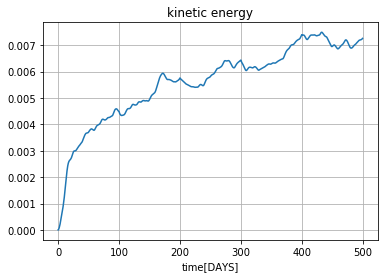

In [4]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [5]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

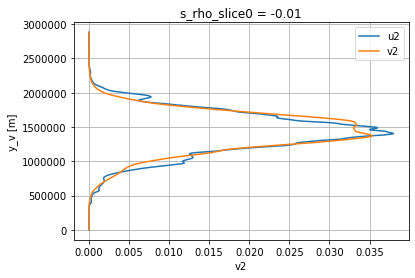

In [7]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()

In [8]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

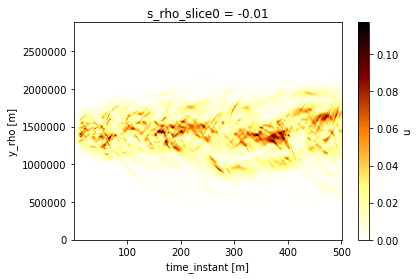

In [9]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape

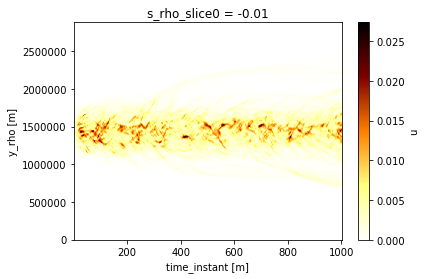

In [9]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape

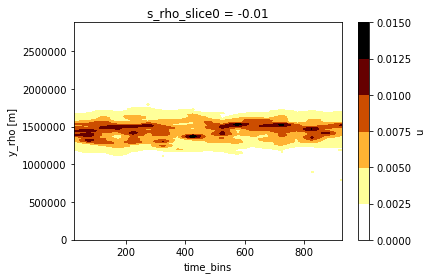

In [11]:
toplt = u2_meanx.groupby_bins('time',np.arange(0,1000,50)).mean('time').squeeze()
toplt.time_bins.values = [t.values.item().mid for t in toplt.time_bins] # contourf won't work otherwise
toplt.plot.contourf(x='time_bins', y='y_rho', cmap='afmhot_r')

--- 

## pictures

In [96]:
r['grid'].y_rho

<xarray.DataArray 'y_rho' (y_rho: 722)>
array([-2.000e+03,  2.000e+03,  6.000e+03, ...,  2.874e+06,  2.878e+06,
        2.882e+06], dtype=float32)
Coordinates:
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
Attributes:
    standard_name:  y_rho
    long_name:      y_rho
    units:          m

In [107]:
def plot_Fy(ax=None):
    p = r.params_output
    if ax:
        ax.axhline(p['fst_ymid']-p['fst_ywid'], color='k')
        ax.axhline(p['fst_ymid']+p['fst_ywid'], color='k')
    else:
        plt.axhline(p['fst_ymid']-p['fst_ywid'], color='k')
        plt.axhline(p['fst_ymid']+p['fst_ywid'], color='k')

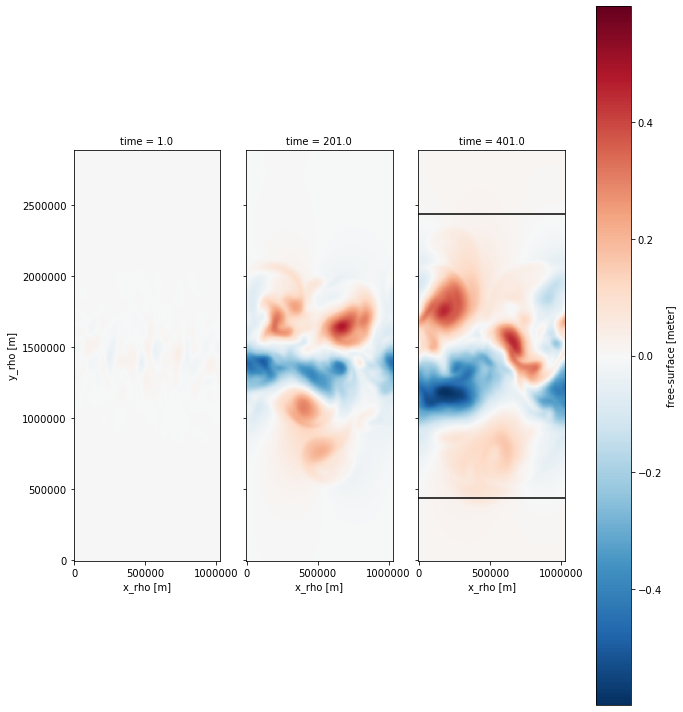

In [108]:
(r['surf']['ssh'].sel(time=slice(0,1000,200))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=3, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,10))
)
plot_Fy()
#plt.axhline?

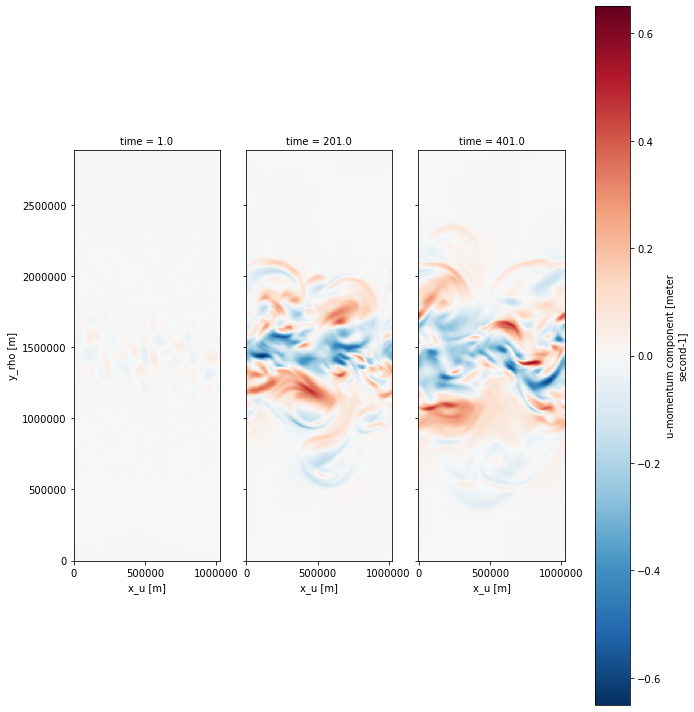

In [10]:
(r['surf']['u'].sel(time=slice(0,1000,200))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=3, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,10))
)

In [10]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

AttributeError: 'Grid' object has no attribute '_metrics'

In [11]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.diff(u, 'eta') + r.xgrid.diff(v, 'xi'))/4e3

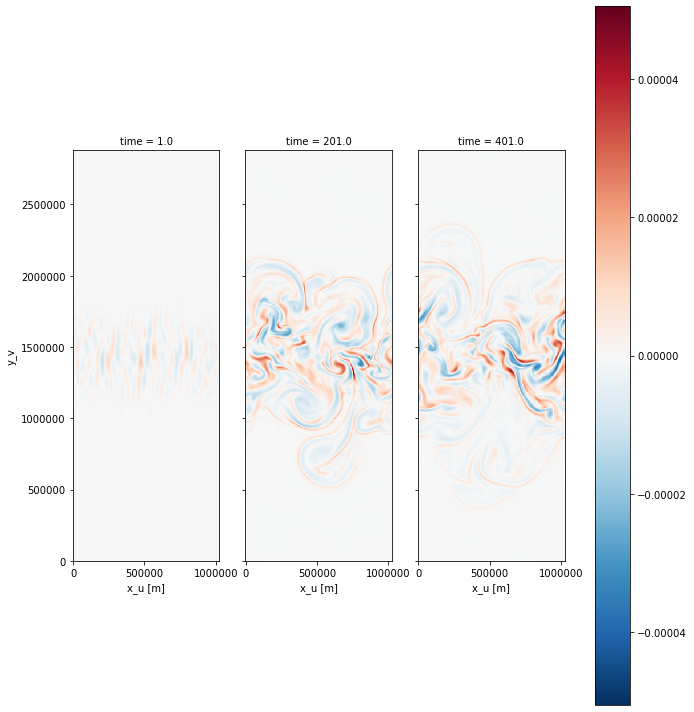

In [14]:
(zeta.sel(time=slice(0,1000,200))
         .plot(x='x_u', y='y_v', col='time', col_wrap=3, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,10))
)

---

## wavenumber spectra with xrft

In [82]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [83]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()
ekehat

<xarray.DataArray (freq_y_rho: 722, freq_x_rho: 258)>
array([[1.22640257e-06, 6.20576529e-06, 1.85377041e-05, ...,
        3.73290525e-05, 1.85377041e-05, 6.20576529e-06],
       [1.86207484e-06, 6.33436549e-06, 1.70128547e-05, ...,
        3.82041178e-05, 2.09655564e-05, 7.38178093e-06],
       [3.63606676e-06, 7.49251986e-06, 1.66810986e-05, ...,
        3.95022637e-05, 2.35152878e-05, 9.77667807e-06],
       ...,
       [6.36167511e-06, 1.32548023e-05, 2.58861201e-05, ...,
        3.89909689e-05, 1.76335244e-05, 9.35885783e-06],
       [3.63606676e-06, 9.77667807e-06, 2.35152878e-05, ...,
        3.61191491e-05, 1.66810986e-05, 7.49251986e-06],
       [1.86207484e-06, 7.38178093e-06, 2.09655564e-05, ...,
        3.63210542e-05, 1.70128547e-05, 6.33436549e-06]])
Coordinates:
  * freq_y_rho          (freq_y_rho) float64 -0.000125 -0.0001247 ... 0.0001247
  * freq_x_rho          (freq_x_rho) float64 -0.000125 -0.000124 ... 0.000124
    freq_x_rho_spacing  float64 9.69e-07
    freq_y_rho_spacing  float64 3.463e-07

In [84]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [km]')

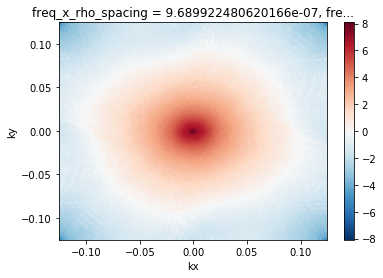

In [85]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [89]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

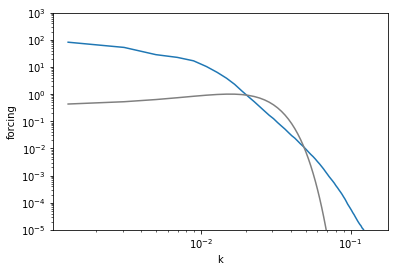

In [90]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3/r.params_output['fst_k']
F_dk = 1e3/r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-5, 1e3), color='0.5')

In [79]:
u = r['surf']['u'].sel(time=slice(0,100,10))
v = r['surf']['v'].sel(time=slice(0,100,10))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2) #.mean('time').persist()

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

/home1/datahome/aponte/xrft/xrft/xrft.py:608: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/home1/datahome/aponte/xrft/xrft/xrft.py:624: RuntimeWarning: invalid value encountered in true_divide
  iso_f = np.ma.masked_invalid(_bincount / area) * kr


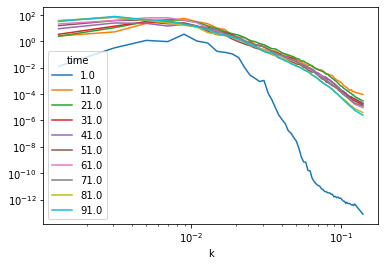

In [81]:
hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')

In [30]:
r.params_output

{'jet_ywidth': 800000.0,
 'jet_weight': 0.0,
 'tdiag_omega': 0.000145,
 'depth': 4000.0,
 'f0': 0.000103,
 'beta': 0.0,
 'yrbeta': 1440000.0,
 'fst_dt': 864000.0,
 'fst_tdecay': 77800000.0,
 'fst_Nmode': 5.0,
 'fst_a': array([0.1, 0.1, 0.1, 0.1, 0.1]),
 'fst_xmid': 512000.0,
 'fst_xwid': 200000.0,
 'fst_ymid': 1440000.0,
 'fst_ywid': 1000000.0,
 'fst_FT': 1000.0,
 'fst_k': 64000.0,
 'fst_dk': 64000.0}

---

In [109]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli